In [1]:
import sys
sys.path.append('..')

from utilities import *

warnings.filterwarnings('ignore')

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

train_data, test_data = sa.divide_data_for_train_and_test(data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
model, design_info, selected_columns = sa.modelization_with_backward_elimination(train_data)


In [3]:
'''Incorrect way of using auto_arima with exogenous variables'''

# auto_arima_model = auto_arima( 
#     y=train_data['volume.sales'],
#     X=train_data[selected_columns],
#     start_p=0,
#     d=1,  
#     start_q=0,
#     max_p=3, 
#     max_q=3,
#     start_P=0,
#     D=1,  # Set seasonal differencing explicitly
#     start_Q=0,
#     max_P=1, 
#     max_Q=1,
#     m=12,  # Monthly data
#     seasonal=True,
#     trace=True,
#     error_action="warn",  # Change to warn to see potential issues
#     suppress_warnings=True,
#     stepwise=True,
#     random_state=42,
#     n_fits=50,
#     information_criterion='aic'
# )

'Incorrect way of using auto_arima with exogenous variables'

#### Create the variable X_train_exog with the selected columns from the regression model

Recreate interactions of all variables

In [4]:
# Create the exogenous variables matrix for auto_arima
# We need to recreate the design matrix using the same transformations

# First, rename columns to match the formula used in modelization_with_backward_elimination
train_data_for_patsy = train_data.copy()
train_data_for_patsy.rename(
    columns={
        "value.sales": "value_sales",
        "unit.sales": "unit_sales", 
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    },
    inplace=True,
)

# Use the same formula as in the regression
formula = "volume_sales ~ (price + C(supermarket) + C(variant) + C(pack_size)) ** 2"

# Create the design matrix
y_design, X_design = patsy.dmatrices(formula, data=train_data_for_patsy, return_type="dataframe")

print("Design matrix shape:", X_design.shape)
print("Design matrix columns:", X_design.columns.tolist())

Design matrix shape: (644, 47)
Design matrix columns: ['Intercept', 'C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-C]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.light]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]', 'C(pack_size)[T.351 - 500 GR]', 'C(pack_size)[T.501 - 700 GR]', 'C(pack_size)[T.701 - 1000 GR]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-D]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-D]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.vegan]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.vegan]', 'C(supermarket)[T.supermarket-D]:C(variant)[T.vegan]', 'C(supermarket)[T.supermarket-B]:C(pack_size)[T.351 - 500 GR]', 'C(supermarket)[T.supermarket-C]:C(pack_size)[T.351 - 500 GR]', 'C(supermarket)[T.supermar

Only select those that were selected in the regression model

In [5]:
# Filter the design matrix to include only the selected columns from backward elimination
# Remove 'Intercept' since auto_arima handles that automatically
selected_columns_no_intercept = [col for col in selected_columns if col != 'Intercept']

print("Selected columns without intercept:", selected_columns_no_intercept)
print("Number of exogenous variables:", len(selected_columns_no_intercept))

# Create the exogenous variables matrix for training
X_train_exog = X_design[selected_columns_no_intercept]

print("Exogenous variables matrix shape:", X_train_exog.shape)
print("Exogenous variables matrix columns:", X_train_exog.columns.tolist())

Selected columns without intercept: ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]', 'C(pack_size)[T.351 - 500 GR]', 'C(pack_size)[T.501 - 700 GR]', 'C(pack_size)[T.701 - 1000 GR]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-D]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.vegan]', 'C(supermarket)[T.supermarket-C]:C(pack_size)[T.351 - 500 GR]', 'C(supermarket)[T.supermarket-D]:C(pack_size)[T.351 - 500 GR]', 'C(supermarket)[T.supermarket-D]:C(pack_size)[T.501 - 700 GR]', 'C(supermarket)[T.supermarket-B]:C(pack_size)[T.701 - 1000 GR]', 'C(variant)[T.light]:C(pack_size)[T.351 - 500 GR]', 'C(variant)[T.vegan]:C(pack_size)[T.351 - 500 GR]', 'C(variant)[T.light]:C(pack_size)[T.501 - 700 G

Comparison between model features and X_train_exog features - Do they match? Yes

In [6]:
# Print the regression model coefficients and their names
print("Regression model coefficients:")
print("=" * 50)
for i, (coef_name, coef_value) in enumerate(zip(model.params.index, model.params.values)):
    print(f"{i+1:2d}. {coef_name:<50} {coef_value:>12.6f}")

print("\n\nX_train_exog columns:")
print("=" * 50)
for i, col_name in enumerate(X_train_exog.columns):
    print(f"{i+1:2d}. {col_name}")

print("\n\nComparison - Do they match?")
print("=" * 50)
model_features = list(model.params.index)
exog_features = list(X_train_exog.columns)

# Remove 'Intercept' from model features for comparison since X_train_exog doesn't have it
model_features_no_intercept = [f for f in model_features if f != 'Intercept']

print(f"Model features (excluding Intercept): {len(model_features_no_intercept)}")
print(f"X_train_exog features: {len(exog_features)}")

if set(model_features_no_intercept) == set(exog_features):
    print("✅ YES - All features match perfectly!")
else:
    print("❌ NO - Features don't match")
    
    missing_in_exog = set(model_features_no_intercept) - set(exog_features)
    missing_in_model = set(exog_features) - set(model_features_no_intercept)
    
    if missing_in_exog:
        print(f"\nFeatures in model but missing in X_train_exog: {len(missing_in_exog)}")
        for feature in missing_in_exog:
            print(f"  - {feature}")
    
    if missing_in_model:
        print(f"\nFeatures in X_train_exog but missing in model: {len(missing_in_model)}")
        for feature in missing_in_model:
            print(f"  - {feature}")

Regression model coefficients:
 1. Intercept                                          12101.529434
 2. C(supermarket)[T.supermarket-B]                    23186.891702
 3. C(supermarket)[T.supermarket-D]                    -105090.039176
 4. C(variant)[T.standard]                             26242.235474
 5. C(variant)[T.vegan]                                75206.390835
 6. C(pack_size)[T.351 - 500 GR]                       82197.774832
 7. C(pack_size)[T.501 - 700 GR]                       21792.130242
 8. C(pack_size)[T.701 - 1000 GR]                      -19934.073669
 9. C(supermarket)[T.supermarket-B]:C(variant)[T.light] -19239.020609
10. C(supermarket)[T.supermarket-C]:C(variant)[T.light] 30044.882830
11. C(supermarket)[T.supermarket-B]:C(variant)[T.standard] -52039.040199
12. C(supermarket)[T.supermarket-C]:C(variant)[T.standard] -32155.935126
13. C(supermarket)[T.supermarket-D]:C(variant)[T.standard] 69131.249607
14. C(supermarket)[T.supermarket-B]:C(variant)[T.vegan] 71122.920

#### Run Auto ARIMA model with exogenous variables

In [7]:
# Now we can run auto_arima with the correct exogenous variables
auto_arima_model = auto_arima( 
    y=train_data['volume.sales'],
    X=X_train_exog,  # Use the properly formatted exogenous variables
    start_p=0,
    d=1,  
    start_q=0,
    max_p=3, 
    max_q=3,
    start_P=0,
    D=1,  # Set seasonal differencing explicitly
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,  # Monthly data
    seasonal=True,
    trace=True,
    error_action="warn",  # Change to warn to see potential issues
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    information_criterion='aic'
)

print("Auto ARIMA model fitted successfully!")
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18700.911, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18700.911, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14983.257, Time=15.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14983.257, Time=15.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=77.71 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=77.71 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15113.277, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15113.277, Time=0.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=30.52 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=30.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=17.79 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=17.79 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=15113.200, Time=9.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=15113.200, Time=9.28 sec
 ARIMA(2,1,0)(1,1,0)[12]         

#### Prepare exogenous variables for forecasting

In [9]:
# Prepare test data for forecasting
# We need to create the same exogenous variables matrix for the test period

# First, rename columns in test data to match the formula
test_data_for_patsy = test_data.copy()
test_data_for_patsy.rename(
    columns={
        "value.sales": "value_sales",
        "unit.sales": "unit_sales", 
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    },
    inplace=True,
)

# Use the same formula as in training
formula = "volume_sales ~ (price + C(supermarket) + C(variant) + C(pack_size)) ** 2"

# Create the design matrix for test data
# To handle missing categorical levels, we'll use the same design_info approach
try:
    # Create design matrix with same structure as training
    X_test_design = patsy.dmatrix(
        formula.split('~')[1].strip(),  # Get the right-hand side of the formula
        data=test_data_for_patsy, 
        return_type="dataframe"
    )
    
    # Check which columns from training are available in test
    available_columns = []
    missing_columns = []
    
    for col in selected_columns_no_intercept:
        if col in X_test_design.columns:
            available_columns.append(col)
        else:
            missing_columns.append(col)
    
    print(f"Available columns in test data: {len(available_columns)}")
    print(f"Missing columns in test data: {len(missing_columns)}")
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        # Create a matrix with all required columns, filling missing ones with zeros
        X_test_exog = pd.DataFrame(0, index=X_test_design.index, columns=selected_columns_no_intercept)
        # Fill available columns with actual values
        for col in available_columns:
            X_test_exog[col] = X_test_design[col]
    else:
        X_test_exog = X_test_design[selected_columns_no_intercept]
    
except Exception as e:
    print(f"Error creating test design matrix: {e}")
    # Fallback: create a simple matrix with available features only
    X_test_exog = pd.DataFrame(0, index=test_data.index, columns=selected_columns_no_intercept)

print("Test exogenous variables matrix shape:", X_test_exog.shape)
print("Test exogenous variables matrix columns:", X_test_exog.columns.tolist())
print("\nTest data period:", test_data.index[0], "to", test_data.index[-1])
print("Number of forecast periods:", len(test_data))

Available columns in test data: 24
Missing columns in test data: 3
Missing columns: ['C(pack_size)[T.501 - 700 GR]', 'C(supermarket)[T.supermarket-D]:C(pack_size)[T.501 - 700 GR]', 'C(variant)[T.light]:C(pack_size)[T.501 - 700 GR]']
Test exogenous variables matrix shape: (161, 27)
Test exogenous variables matrix columns: ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]', 'C(pack_size)[T.351 - 500 GR]', 'C(pack_size)[T.501 - 700 GR]', 'C(pack_size)[T.701 - 1000 GR]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.light]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-C]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-D]:C(variant)[T.standard]', 'C(supermarket)[T.supermarket-B]:C(variant)[T.vegan]', 'C(supermarket)[T.supermarket-C]:C(pack_size)[T.351 - 500 GR]', 'C(supermarket)[T.supermarket-D]:C(pack_size)[T.351 - 500

#### Generate forecasts using Auto ARIMA model

In [10]:
# Generate forecasts using the auto_arima model
n_periods = len(test_data)

# Generate forecasts with confidence intervals
forecasts, conf_int = auto_arima_model.predict(
    n_periods=n_periods,
    X=X_test_exog,
    return_conf_int=True,
    alpha=0.05  # 95% confidence interval
)

print("Forecasts generated successfully!")
print(f"Number of forecasts: {len(forecasts)}")
print(f"Forecast period: {test_data.index[0]} to {test_data.index[-1]}")

# Create a DataFrame with forecasts and confidence intervals
forecast_df = pd.DataFrame({
    'actual': test_data['volume.sales'].values,
    'forecast': forecasts,
    'lower_ci': conf_int[:, 0],
    'upper_ci': conf_int[:, 1],
    'date': test_data.index
})

# Calculate forecast errors
forecast_df['error'] = forecast_df['actual'] - forecast_df['forecast']
forecast_df['abs_error'] = np.abs(forecast_df['error'])
forecast_df['pct_error'] = (forecast_df['error'] / forecast_df['actual']) * 100
forecast_df['abs_pct_error'] = np.abs(forecast_df['pct_error'])

print("\nForecast summary:")
print(forecast_df.head(10))

Forecasts generated successfully!
Number of forecasts: 161
Forecast period: 25 to 35

Forecast summary:
         actual      forecast       lower_ci       upper_ci  date  \
644    9809.650  33065.961597  -34274.575109  100406.498302    25   
645    2194.640  16526.112288  -55010.207457   88062.432033    28   
646     126.756  11358.700462  -64303.822621   87021.223545    28   
647  114778.590  55565.942950  -24116.524600  135248.410501    28   
648   94810.450  96934.355622    9769.310706  184099.400537    28   
649   33025.810  30711.389292  -60973.560183  122396.338766    28   
650   11196.000  99276.281573    3235.906740  195316.656407    28   
651    1546.440  -2661.287345 -102898.275982   97575.701291    28   
652   18136.150  53869.112748  -50843.631332  158581.856828    28   
653   31921.500   5765.786404 -102938.252205  114469.825013    28   

            error     abs_error    pct_error  abs_pct_error  
644 -23256.311597  23256.311597  -237.075855     237.075855  
645 -14331.4

#### Evaluate forecast performance

In [11]:
# Calculate forecast accuracy metrics
def calculate_metrics(actual, predicted):
    """Calculate various forecast accuracy metrics"""
    # Remove any zero values to avoid division by zero in MAPE
    mask = actual != 0
    actual_filtered = actual[mask]
    predicted_filtered = predicted[mask]
    
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    
    # MAPE calculation (avoiding division by zero)
    if len(actual_filtered) > 0:
        mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100
    else:
        mape = np.nan
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Calculate metrics for Auto ARIMA forecasts
auto_arima_metrics = calculate_metrics(forecast_df['actual'].values, forecast_df['forecast'].values)

print("Auto ARIMA Model Forecast Performance:")
print("=" * 50)
for metric, value in auto_arima_metrics.items():
    if not np.isnan(value):
        print(f"{metric:<6}: {value:>10.4f}")
    else:
        print(f"{metric:<6}: {value:>10}")

# Additional statistics
print(f"\nForecast Statistics:")
print(f"Mean Actual: {forecast_df['actual'].mean():.4f}")
print(f"Mean Forecast: {forecast_df['forecast'].mean():.4f}")
print(f"Std Actual: {forecast_df['actual'].std():.4f}")
print(f"Std Forecast: {forecast_df['forecast'].std():.4f}")
print(f"Correlation: {forecast_df['actual'].corr(forecast_df['forecast']):.4f}")

# Show distribution of percentage errors
print(f"\nPercentage Error Distribution:")
print(f"Mean Absolute Percentage Error: {forecast_df['abs_pct_error'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {forecast_df['abs_pct_error'].median():.2f}%")
print(f"Max Absolute Percentage Error: {forecast_df['abs_pct_error'].max():.2f}%")
print(f"Min Absolute Percentage Error: {forecast_df['abs_pct_error'].min():.2f}%")

Auto ARIMA Model Forecast Performance:
MSE   : 3688973661.7505
RMSE  : 60736.9217
MAE   : 39627.6046
MAPE  : 268154.7494

Forecast Statistics:
Mean Actual: 49806.0501
Mean Forecast: 63765.8288
Std Actual: 75781.4666
Std Forecast: 65718.9792
Correlation: 0.6572

Percentage Error Distribution:
Mean Absolute Percentage Error: 268154.75%
Median Absolute Percentage Error: 115.73%
Max Absolute Percentage Error: 21081885.18%
Min Absolute Percentage Error: 0.31%


#### Visualize forecast results

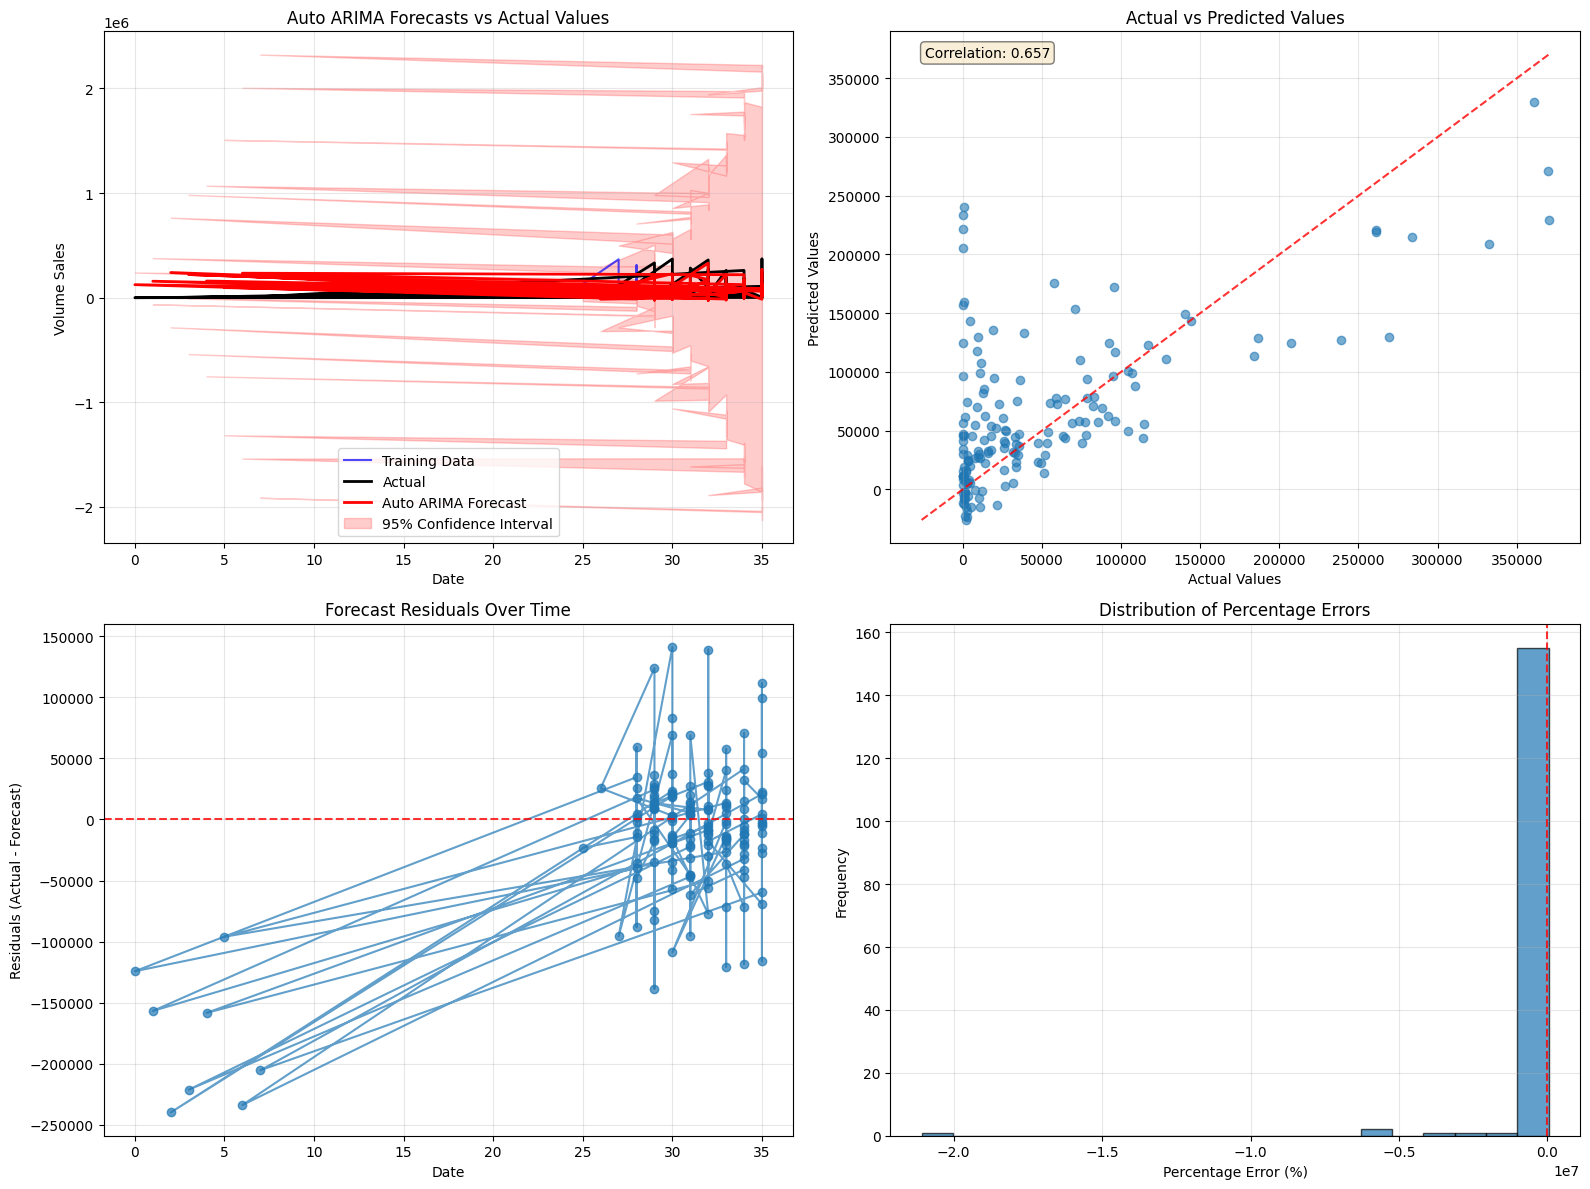


Auto ARIMA Model Summary:
Model Order: (3, 1, 0)
Seasonal Order: (1, 1, 0, 12)
AIC: 14902.9714
BIC: 15045.2852
Number of exogenous variables: 27


In [12]:
# Create comprehensive visualization of forecast results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time series plot with forecasts and confidence intervals
ax1 = axes[0, 0]
# Plot last part of training data for context
train_tail = train_data.tail(24)  # Last 24 months of training data
ax1.plot(train_tail.index, train_tail['volume.sales'], 
         label='Training Data', color='blue', alpha=0.7)
ax1.plot(forecast_df['date'], forecast_df['actual'], 
         label='Actual', color='black', linewidth=2)
ax1.plot(forecast_df['date'], forecast_df['forecast'], 
         label='Auto ARIMA Forecast', color='red', linewidth=2)
ax1.fill_between(forecast_df['date'], forecast_df['lower_ci'], forecast_df['upper_ci'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')
ax1.set_title('Auto ARIMA Forecasts vs Actual Values')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume Sales')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Actual vs Predicted scatter plot
ax2 = axes[0, 1]
ax2.scatter(forecast_df['actual'], forecast_df['forecast'], alpha=0.6)
# Add diagonal line for perfect prediction
min_val = min(forecast_df['actual'].min(), forecast_df['forecast'].min())
max_val = max(forecast_df['actual'].max(), forecast_df['forecast'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Actual vs Predicted Values')
ax2.grid(True, alpha=0.3)

# Add correlation coefficient to the plot
corr = forecast_df['actual'].corr(forecast_df['forecast'])
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

# 3. Residuals plot
ax3 = axes[1, 0]
ax3.plot(forecast_df['date'], forecast_df['error'], marker='o', linestyle='-', alpha=0.7)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax3.set_title('Forecast Residuals Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residuals (Actual - Forecast)')
ax3.grid(True, alpha=0.3)

# 4. Percentage errors histogram
ax4 = axes[1, 1]
ax4.hist(forecast_df['pct_error'], bins=20, alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', alpha=0.8)
ax4.set_title('Distribution of Percentage Errors')
ax4.set_xlabel('Percentage Error (%)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model summary
print("\nAuto ARIMA Model Summary:")
print("=" * 50)
print(f"Model Order: {auto_arima_model.order}")
print(f"Seasonal Order: {auto_arima_model.seasonal_order}")
print(f"AIC: {auto_arima_model.aic():.4f}")
print(f"BIC: {auto_arima_model.bic():.4f}")
print(f"Number of exogenous variables: {len(selected_columns_no_intercept)}")

#### Export forecast results

In [13]:
# Create a comprehensive results summary
results_summary = {
    'Model': 'Auto ARIMA with Exogenous Variables',
    'Model Order': str(auto_arima_model.order),
    'Seasonal Order': str(auto_arima_model.seasonal_order),
    'AIC': auto_arima_model.aic(),
    'BIC': auto_arima_model.bic(),
    'Number of Exogenous Variables': len(selected_columns_no_intercept),
    'Forecast Period': f"{test_data.index[0]} to {test_data.index[-1]}",
    'Number of Forecasts': len(forecasts),
    **auto_arima_metrics
}

# Convert to DataFrame for better display
results_df = pd.DataFrame(list(results_summary.items()), columns=['Metric', 'Value'])
print("Complete Forecast Results Summary:")
print("=" * 50)
print(results_df.to_string(index=False))

# Save forecast results to CSV
forecast_output = forecast_df.copy()
forecast_output['model'] = 'Auto ARIMA'
forecast_output['model_order'] = str(auto_arima_model.order)
forecast_output['seasonal_order'] = str(auto_arima_model.seasonal_order)

# Save to CSV file
output_filename = '../tests/auto_arima_forecast_results.csv'
forecast_output.to_csv(output_filename, index=False)
print(f"\nForecast results saved to: {output_filename}")

# Display the first few and last few forecast results
print(f"\nFirst 5 forecast results:")
print(forecast_df[['date', 'actual', 'forecast', 'abs_pct_error']].head().to_string(index=False))
print(f"\nLast 5 forecast results:")
print(forecast_df[['date', 'actual', 'forecast', 'abs_pct_error']].tail().to_string(index=False))

Complete Forecast Results Summary:
                       Metric                               Value
                        Model Auto ARIMA with Exogenous Variables
                  Model Order                           (3, 1, 0)
               Seasonal Order                       (1, 1, 0, 12)
                          AIC                        14902.971395
                          BIC                        15045.285182
Number of Exogenous Variables                                  27
              Forecast Period                            25 to 35
          Number of Forecasts                                 161
                          MSE                   3688973661.750529
                         RMSE                        60736.921734
                          MAE                        39627.604641
                         MAPE                        268154.74941

Forecast results saved to: ../tests/auto_arima_forecast_results.csv

First 5 forecast results:
 date     a